In [2]:
# to download module
!pip install segment-anything

# to download weights
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2023-08-01 08:49:30--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.249.141.40, 13.249.141.108, 13.249.141.13, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.249.141.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   244MB/s    in 14s     

2023-08-01 08:49:43 (180 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [3]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

In [4]:
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    if torch.backends.mps.is_available():
        return torch.device('mps')
    return torch.device("cpu")

In [5]:
DEVICE = get_device()
DEVICE

device(type='cuda')

In [7]:
sam = sam_model_registry["vit_h"](checkpoint="/content/sam_vit_h_4b8939.pth")
sam.to(DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [8]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x["area"]), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for ann in sorted_anns:
        m = ann["segmentation"]
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:, :, i] = color_mask[i]
        np.dstack((img, m * 0.35))
        ax.imshow(np.dstack((img, m * 0.35)))

In [9]:
!wget -O sample_image.jpg https://st2.depositphotos.com/1001071/6267/i/450/depositphotos_62672929-stock-photo-boats-and-people-on-the.jpg

--2023-08-01 08:50:54--  https://st2.depositphotos.com/1001071/6267/i/450/depositphotos_62672929-stock-photo-boats-and-people-on-the.jpg
Resolving st2.depositphotos.com (st2.depositphotos.com)... 104.98.92.21
Connecting to st2.depositphotos.com (st2.depositphotos.com)|104.98.92.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86978 (85K) [image/jpeg]
Saving to: ‘sample_image.jpg’

sample_image.jpg    100%[===================>]  84.94K  --.-KB/s    in 0.02s   

2023-08-01 08:50:54 (3.84 MB/s) - ‘sample_image.jpg’ saved [86978/86978]



(400, 600, 3)


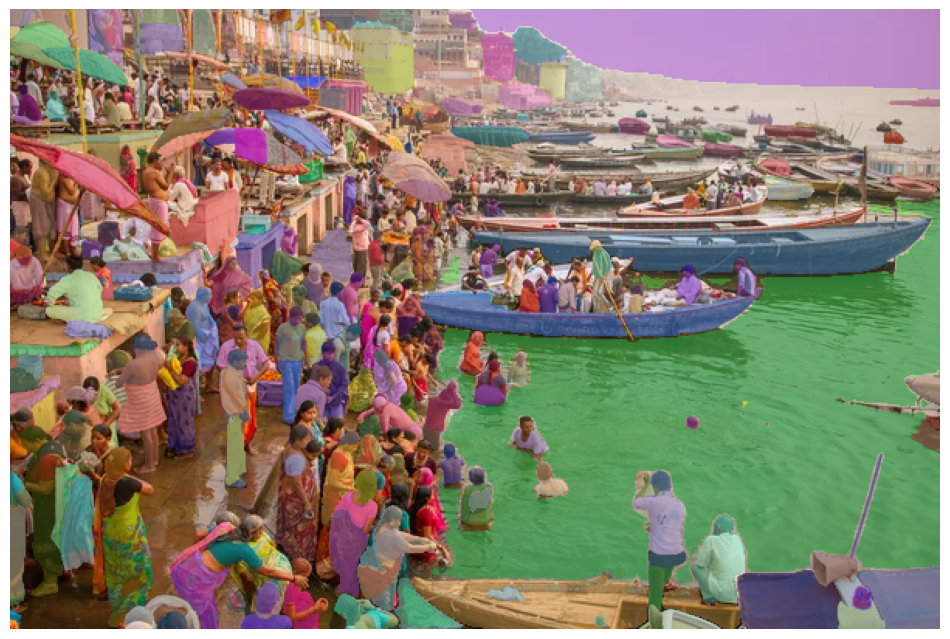

In [11]:
mask_generator = SamAutomaticMaskGenerator(sam)
image_path = "/content/sample_image.jpg"
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
print(image.shape)
masks = mask_generator.generate(image)
plt.figure(figsize=(12, 9))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.savefig(os.path.join('inference.png'), bbox_inches='tight')
plt.show()